<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2026/blob/main/Week_04/Week_04_Hands_on_Flow_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Matching Planner
Generated with OpenAI ChatGPT 5.2.
Feb. 08 2026

In [1]:
# ==============================
# Week 04 Colab: Vision (2D) -> Flow Matching Planner -> Simple Controller
# ==============================
# This notebook is self-contained:
#   1) Create synthetic 2D "scene images" with start/goal markers
#   2) "VL" step (minimal): detect start/goal from the image (simple CV)
#   3) Train a conditional Flow Matching model that generates 2D trajectories
#   4) Sample trajectories via ODE rollout (Euler)
#   5) (Optional) simple tracking controller demo
#
# Author: (your name)
# ==============================

!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 || true
!pip -q install numpy matplotlib tqdm opencv-python

import math, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# ---------- Reproducibility ----------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

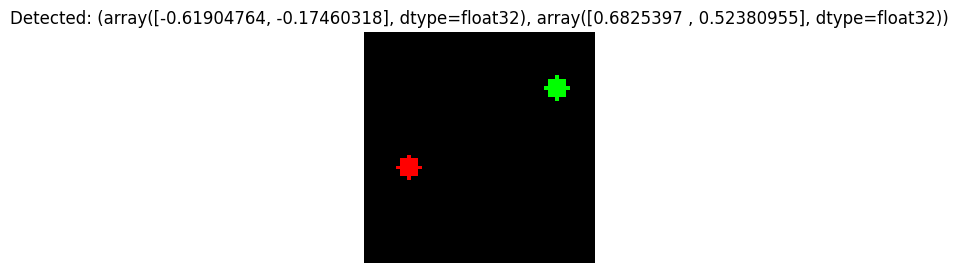

In [3]:
# ==========================================
# 1) Synthetic "scene images" with start/goal
# ==========================================
# We render a 64x64 image with:
#   - a red dot = start
#   - a green dot = goal
#
# Then we "detect" those dots by simple color thresholding.
#
# This is a minimal stand-in for a VL/VLM module:
# - Students see: perception -> geometry -> planning
# - No heavy models required in Week 04

H, W = 64, 64

def render_scene(start_xy, goal_xy, radius=3):
    """
    start_xy, goal_xy in normalized coordinates [-1,1]x[-1,1]
    returns BGR uint8 image (H,W,3)
    """
    img = np.zeros((H, W, 3), dtype=np.uint8)

    def to_px(xy):
        x, y = xy
        # map [-1,1] -> [0,W-1], [0,H-1] with y up -> image y down
        px = int((x + 1) * 0.5 * (W - 1))
        py = int((1 - (y + 1) * 0.5) * (H - 1))
        return px, py

    sx, sy = to_px(start_xy)
    gx, gy = to_px(goal_xy)

    # BGR colors for OpenCV:
    # start red, goal green
    cv2.circle(img, (sx, sy), radius, (0, 0, 255), -1)
    cv2.circle(img, (gx, gy), radius, (0, 255, 0), -1)

    return img

def detect_start_goal(img_bgr):
    """
    Simple CV detection:
      - threshold red and green,
      - compute centroids,
      - map back to normalized [-1,1] coordinates.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # red mask (two ranges in HSV)
    lower1 = np.array([0, 120, 50]); upper1 = np.array([10, 255, 255])
    lower2 = np.array([170, 120, 50]); upper2 = np.array([180, 255, 255])
    mask_red = cv2.inRange(hsv, lower1, upper1) | cv2.inRange(hsv, lower2, upper2)

    # green mask
    lower_g = np.array([35, 80, 50]); upper_g = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_g, upper_g)

    def centroid(mask):
        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            return None
        return float(xs.mean()), float(ys.mean())

    c_red = centroid(mask_red)
    c_green = centroid(mask_green)
    if c_red is None or c_green is None:
        return None

    def to_norm(cx, cy):
        # invert mapping used above
        x = (cx / (W - 1)) * 2 - 1
        y = -((cy / (H - 1)) * 2 - 1)
        return np.array([x, y], dtype=np.float32)

    start = to_norm(*c_red)
    goal = to_norm(*c_green)
    return start, goal

# Quick visual sanity check
start_xy = np.array([-0.6, -0.2], dtype=np.float32)
goal_xy  = np.array([ 0.7,  0.5], dtype=np.float32)
img = render_scene(start_xy, goal_xy)
det = detect_start_goal(img)

plt.figure(figsize=(3,3))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Detected: {det}")
plt.axis("off")
plt.show()


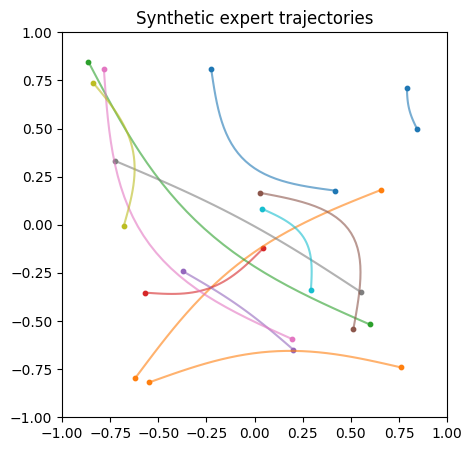

In [4]:
# ==========================================
# 2) Trajectory dataset generator (2D paths)
# ==========================================
# We want a dataset of "expert" trajectories between (start, goal).
# For Week 04 we generate *smooth curved paths* analytically.
#
# Each trajectory is a sequence of T waypoints in R^2.

def make_smooth_trajectory(start, goal, T=32):
    """
    start, goal: np arrays shape (2,) in [-1,1]
    Create a smooth curve using a perpendicular sinusoidal bump.
    """
    start = np.asarray(start, dtype=np.float32)
    goal  = np.asarray(goal,  dtype=np.float32)
    v = goal - start
    norm = np.linalg.norm(v) + 1e-6
    u = v / norm

    # perpendicular direction
    perp = np.array([-u[1], u[0]], dtype=np.float32)

    # random curvature amplitude
    amp = np.random.uniform(-0.35, 0.35) * min(1.0, norm)

    ts = np.linspace(0.0, 1.0, T, dtype=np.float32)
    pts = []
    for t in ts:
        base = (1 - t) * start + t * goal
        bump = amp * math.sin(math.pi * t)  # 0 at ends, max mid
        pts.append(base + bump * perp)
    return np.stack(pts, axis=0)  # (T,2)

# visualize a few random trajectories
T = 32
plt.figure(figsize=(5,5))
for _ in range(12):
    s = np.random.uniform(-0.9, 0.9, size=(2,)).astype(np.float32)
    g = np.random.uniform(-0.9, 0.9, size=(2,)).astype(np.float32)
    tr = make_smooth_trajectory(s, g, T=T)
    plt.plot(tr[:,0], tr[:,1], alpha=0.6)
    plt.scatter([s[0], g[0]],[s[1], g[1]], s=10)
plt.xlim(-1,1); plt.ylim(-1,1); plt.gca().set_aspect("equal", "box")
plt.title("Synthetic expert trajectories")
plt.show()


In [5]:
# ===========================================================
# 3) Conditional Flow Matching for trajectories (core section)
# ===========================================================
# We model the *entire trajectory* as a single vector in R^(2T):
#   x in R^(2T)  represents concatenated waypoints.
#
# We train an ODE vector field v_theta(x,t | c) that transports
# noise x0 -> data x1 (expert trajectory), conditioned on c = (start,goal).
#
# Training objective (simple linear coupling):
#   x(t) = (1-t)*x0 + t*x1
#   v*(t) = x1 - x0
#   L = || v_theta(x(t),t,c) - v*(t) ||^2

T = 32
D = 2*T  # trajectory vector dimension

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, t):
        # t: (B,1)
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(math.log(1.0), math.log(1000.0), half, device=t.device)
        )  # (half,)
        ang = t * freqs[None, :] * 2*math.pi
        emb = torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return self.mlp(emb)

class FlowField(nn.Module):
    def __init__(self, traj_dim, cond_dim=4, time_dim=64, hidden=512):
        super().__init__()
        self.time = TimeEmbedding(time_dim)
        in_dim = traj_dim + cond_dim + time_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, traj_dim),
        )

    def forward(self, x, t, cond):
        # x: (B, D), t: (B,1), cond: (B,4)
        te = self.time(t)  # (B,time_dim)
        h = torch.cat([x, cond, te], dim=-1)
        return self.net(h)

model = FlowField(traj_dim=D, cond_dim=4, time_dim=64, hidden=512).to(device)
sum(p.numel() for p in model.parameters()) / 1e6


0.371904

In [6]:
# ---------------------------
# Training data sampler
# ---------------------------
def sample_batch(batch_size, T=32):
    # sample start/goal in [-0.9,0.9]
    s = np.random.uniform(-0.9, 0.9, size=(batch_size, 2)).astype(np.float32)
    g = np.random.uniform(-0.9, 0.9, size=(batch_size, 2)).astype(np.float32)

    trajs = np.stack([make_smooth_trajectory(s[i], g[i], T=T) for i in range(batch_size)], axis=0)  # (B,T,2)
    x1 = trajs.reshape(batch_size, -1)  # (B,2T)
    cond = np.concatenate([s, g], axis=-1)  # (B,4)
    return torch.tensor(x1), torch.tensor(cond)

# quick check shapes
x1, cond = sample_batch(8, T=T)
x1.shape, cond.shape


(torch.Size([8, 64]), torch.Size([8, 4]))

In [7]:
# ---------------------------
# Flow Matching training loop
# ---------------------------
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

def train_flow_matching(steps=6000, batch_size=256, log_every=200):
    model.train()
    pbar = tqdm(range(steps))
    for step in pbar:
        x1, cond = sample_batch(batch_size, T=T)
        x1 = x1.to(device)
        cond = cond.to(device)

        # base noise (same dimension as trajectory vector)
        x0 = torch.randn_like(x1)

        # sample time
        t = torch.rand(batch_size, 1, device=device)

        # linear interpolation
        xt = (1 - t) * x0 + t * x1

        # target velocity
        v_star = x1 - x0

        # predicted velocity
        v_hat = model(xt, t, cond)

        loss = F.mse_loss(v_hat, v_star)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if (step + 1) % log_every == 0:
            pbar.set_description(f"step {step+1}/{steps} | loss {loss.item():.4f}")

train_flow_matching(steps=4000, batch_size=256, log_every=200)


  0%|          | 0/4000 [00:00<?, ?it/s]

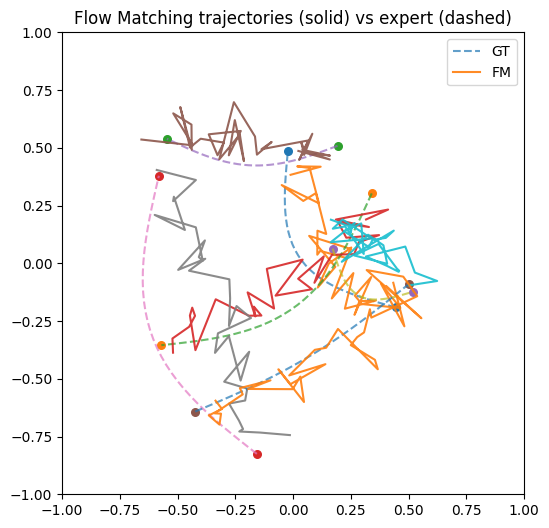

In [8]:
# ==========================================
# 4) Sampling: roll out ODE with Euler steps
# ==========================================
@torch.no_grad()
def sample_trajectory(cond, n_steps=50):
    """
    cond: (B,4) tensor on device
    Returns: (B,T,2) trajectory points
    """
    model.eval()
    B = cond.shape[0]
    x = torch.randn(B, D, device=device)  # x(0) ~ N(0,I)
    t0, t1 = 0.0, 1.0
    dt = (t1 - t0) / n_steps

    t = torch.full((B,1), t0, device=device)
    for _ in range(n_steps):
        v = model(x, t, cond)
        x = x + dt * v
        t = t + dt

    traj = x.reshape(B, T, 2).detach().cpu().numpy()
    return traj

# Visualize samples vs "expert" for random conditions
B = 6
x1_gt, cond = sample_batch(B, T=T)
cond = cond.to(device)

traj_pred = sample_trajectory(cond, n_steps=60)
traj_gt = x1_gt.reshape(B, T, 2).numpy()

plt.figure(figsize=(6,6))
for i in range(B):
    s = cond[i,:2].detach().cpu().numpy()
    g = cond[i,2:].detach().cpu().numpy()
    plt.plot(traj_gt[i,:,0], traj_gt[i,:,1], linestyle="--", alpha=0.7, label="GT" if i==0 else None)
    plt.plot(traj_pred[i,:,0], traj_pred[i,:,1], alpha=0.9, label="FM" if i==0 else None)
    plt.scatter([s[0], g[0]], [s[1], g[1]], s=30)
plt.xlim(-1,1); plt.ylim(-1,1); plt.gca().set_aspect("equal", "box")
plt.legend()
plt.title("Flow Matching trajectories (solid) vs expert (dashed)")
plt.show()


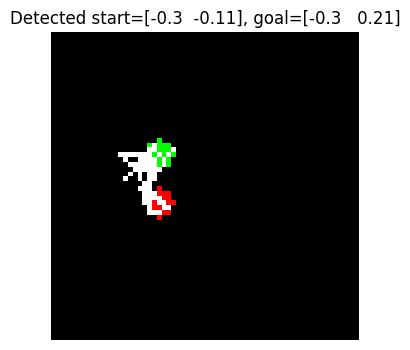

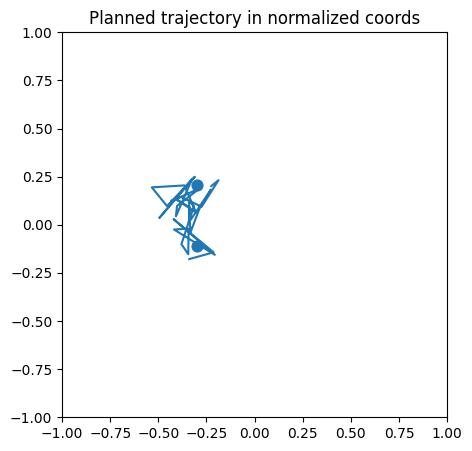

In [9]:
# ======================================================
# 5) End-to-end demo: Image -> detect -> FM -> visualize
# ======================================================
@torch.no_grad()
def plan_from_image(img_bgr, n_steps=60):
    det = detect_start_goal(img_bgr)
    if det is None:
        raise RuntimeError("Could not detect start/goal.")
    start, goal = det
    cond = torch.tensor(np.concatenate([start, goal])[None, :], dtype=torch.float32, device=device)
    traj = sample_trajectory(cond, n_steps=n_steps)[0]  # (T,2)
    return start, goal, traj

# Create a random scene, plan, and overlay trajectory on image
start_xy = np.random.uniform(-0.9, 0.9, size=(2,)).astype(np.float32)
goal_xy  = np.random.uniform(-0.9, 0.9, size=(2,)).astype(np.float32)
img = render_scene(start_xy, goal_xy)

start_d, goal_d, traj = plan_from_image(img, n_steps=60)

# draw trajectory on image
img_vis = img.copy()

def norm_to_px(xy):
    x, y = float(xy[0]), float(xy[1])
    px = int((x + 1) * 0.5 * (W - 1))
    py = int((1 - (y + 1) * 0.5) * (H - 1))
    return px, py

for k in range(T-1):
    p1 = norm_to_px(traj[k])
    p2 = norm_to_px(traj[k+1])
    cv2.line(img_vis, p1, p2, (255, 255, 255), 1)  # white polyline

plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Detected start={start_d.round(2)}, goal={goal_d.round(2)}")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(traj[:,0], traj[:,1])
plt.scatter([start_d[0], goal_d[0]], [start_d[1], goal_d[1]], s=60)
plt.xlim(-1,1); plt.ylim(-1,1); plt.gca().set_aspect("equal","box")
plt.title("Planned trajectory in normalized coords")
plt.show()


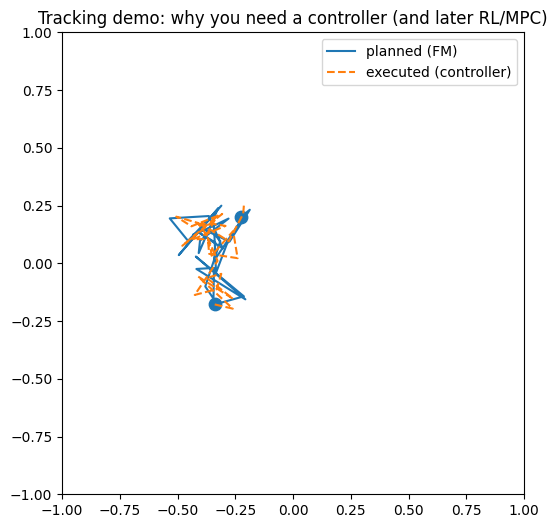

In [10]:
# ======================================================
# 6) (Optional) Simple tracker controller demo (no RL)
# ======================================================
# We simulate a point-mass that tries to follow planned waypoints
# with a proportional controller + injected disturbances.

def track_trajectory(traj, K=0.8, noise_std=0.02):
    """
    traj: (T,2) desired waypoints
    returns executed positions (T,2)
    """
    x = traj[0].copy()
    xs = [x.copy()]
    for t in range(1, len(traj)):
        target = traj[t]
        u = K * (target - x)
        # disturbance
        x = x + u + np.random.randn(2).astype(np.float32) * noise_std
        xs.append(x.copy())
    return np.stack(xs, axis=0)

exec_traj = track_trajectory(traj, K=0.7, noise_std=0.03)

plt.figure(figsize=(6,6))
plt.plot(traj[:,0], traj[:,1], label="planned (FM)")
plt.plot(exec_traj[:,0], exec_traj[:,1], label="executed (controller)", linestyle="--")
plt.scatter([traj[0,0], traj[-1,0]],[traj[0,1], traj[-1,1]], s=80)
plt.xlim(-1,1); plt.ylim(-1,1); plt.gca().set_aspect("equal","box")
plt.legend()
plt.title("Tracking demo: why you need a controller (and later RL/MPC)")
plt.show()


In [ ]:
# =========================
# Notes for your lecture/lab
# =========================
# - What students should observe:
#   1) FM produces smooth, plausible trajectories conditioned on (start, goal)
#   2) The controller can deviate under disturbances
#   3) This motivates "RL as a tracker" in Week 05/06
#
# - Extensions you can assign:
#   A) Add obstacles in the image and encode them in cond.
#   B) Train FM to go around obstacles (change expert generator).
#   C) Replace simple controller with MPC or (later) RL.
#
# Done.
